# Problem Definition:

Using historic from 2012 to 2018 from a La Fe reservoir in Medellin, Colombia, to estimate manganese Alarm levels using Machine learning algorithms using analytical parameters from Source Water Monitors that measure pH, Temperature, Dissolve Oxygen, Conductivity, ORP,  Color, Turbidity, TOC and UV. 

<img src="DATOS.JPG" width=1500 height=1600 />
Captation Tower data

The data were sampled from three submersion levels at the pump station located at the suction tower that supplies raw water for the "La Ayura Plant."
<center>
    <img src="TORRE.JPG"  width=200 height=200 />  <img src="TORRE2.JPG"  width=200 height=300 />
</center>


# Hypotesis:
The hypothesis is to use analytical instrumentation from water source monitor (pH, Temp, OD, ORP, Conductivity, Color, and Turbidity) to estimate alarm level of Manganese greater than 0.1 mg/l and 0.05 mg/l

<center><img src="TABLE.JPG" width=500 height=400 /></center>
Data structure for training


<center><img src="MODEL.JPG" width=1000 height=800 /></center>
Machine learning model


### Import the necessary packages

In [1]:
# Importing lybraries

import numpy as np                             #NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices
import pandas as pd                            #Pandas is a software library written for the Python programming language for data manipulation and analysis. 
import matplotlib.pyplot as plt                #Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy
import sklearn                                 #Scikit-learn is a machine learning library that Features various classification, regression and clustering algorithms including support-vector machine, LDA, etc
import seaborn as sns
from matplotlib.animation import FuncAnimation
#%matplotlib qt

In [2]:
# Importing function from Scikit-learn 
from sklearn.model_selection import train_test_split                                    #Fuction for spliting datasets (training, testing)
from sklearn.model_selection import RepeatedStratifiedKFold                             #Function Stratified K Fold Cross Validation
from sklearn.preprocessing import StandardScaler                                        #Fuction for standardizes features by subtracting the mean and then scaling to unit variance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA             #Fuction for Linear discrimination analisys function.
from sklearn.model_selection import cross_val_score                                     #Function for evaluate a score by cross-validation
from sklearn.metrics import confusion_matrix                                            #A confusion matrix is a table that used to describe the performance of a classification model 
from sklearn.metrics import accuracy_score                                              # This function computes subset accuracy:
from sklearn.metrics import mean_absolute_error as mae                                  # Function to calculate mean absolute error i
from sklearn.metrics import r2_score                                                    # Coefficient of determination also called as R2 score is used to evaluate the performance of a linear regression model
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

## 1) Perform an Exploratory Data Analysis on the data 

### Read the dataset

In [3]:
#Read data set
filename = "Source_Water_Mon_Mang_PCA.csv"
DATADIR = 'C:\\Users\\AlcalaF\\Documents\\projects\\dataplayground\\data'
mydata = pd.read_csv (DATADIR + '/'+ filename)
mydata.head()


,pH,Temp,OD,Cond,Redox,Mang,Color,Turb,TOC
0,7.3,19.6,7.5,43.6,209.0,0.015,8.0,1,1.753
1,7.0,18.6,6.8,51.3,216.9,0.028,16.0,2,1.608
2,6.8,17.5,5.2,55.4,214.1,0.036,12.0,18,1.963
3,7.3,19.3,7.7,41.4,205.8,0.052,11.0,3,2.244
4,7.3,20.0,7.4,41.9,193.7,0.020,13.0,1,1.664


In [4]:
# Produce data information
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pH      554 non-null    float64
 1   Temp    554 non-null    float64
 2   OD      554 non-null    float64
 3   Cond    554 non-null    float64
 4   Redox   554 non-null    float64
 5   Mang    554 non-null    float64
 6   Color   554 non-null    float64
 7   Turb    554 non-null    int64  
 8   TOC     554 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 39.1 KB


In [5]:
#Replace missing values by the mean of each column
mydata = mydata.apply(lambda x: x.fillna(x.mean()),axis=0)
#Alarm level to predict (mg/l)
Alarm_SP = 0.1

In [6]:
#Inserting manganese alarm as True/False  
mydata["Alarm_M"] = (mydata['Mang'] > Alarm_SP)
mydata.head()

,pH,Temp,OD,Cond,Redox,Mang,Color,Turb,TOC,Alarm_M
0,7.3,19.6,7.5,43.6,209.0,0.015,8.0,1,1.753,False
1,7.0,18.6,6.8,51.3,216.9,0.028,16.0,2,1.608,False
2,6.8,17.5,5.2,55.4,214.1,0.036,12.0,18,1.963,False
3,7.3,19.3,7.7,41.4,205.8,0.052,11.0,3,2.244,False
4,7.3,20.0,7.4,41.9,193.7,0.020,13.0,1,1.664,False


#### Split Data

In [7]:
X = mydata.drop(["Mang","Alarm_M" ], axis=1)
y = mydata["Alarm_M"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 443
Number of rows in test data = 111


In [10]:
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Percentage of classes in training set:
Alarm_M
False    0.948081
True     0.051919
Name: proportion, dtype: float64
Percentage of classes in test set:
Alarm_M
False    0.918919
True     0.081081
Name: proportion, dtype: float64


## 4) Model building - Logistic Regression 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Plots a confusion matrix and bar chart of TP, TN, FP, FN for a given classification model, predictors, and target.
    
    Parameters:
    - model: Trained scikit-learn model (classifier).
    - predictors: Input features (predictors) as a numpy array or pandas DataFrame.
    - target: Actual target values (labels) as a numpy array or pandas Series.
    - threshold: Threshold for classifying instances into the positive class (default is 0.5).
    """
    # Predict the probabilities for the positive class
    probas = model.predict_proba(predictors)[:, 1]
    
    # Apply the threshold to convert probabilities to class predictions
    predictions = (probas >= threshold).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(target, predictions)
    TN, FP, FN, TP = cm.ravel()
    
    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    disp.plot(cmap=plt.cm.Blues, ax=ax[0])
    ax[0].set_title('Confusion Matrix with Threshold: {}'.format(threshold))
    
    # Bar chart for TP, TN, FP, FN
    ax[1].bar(['TN', 'FP', 'FN', 'TP'], [TN, FP, FN, TP], color=['green', 'red', 'orange', 'blue'])
    ax[1].set_title('TP, TN, FP, FN Counts')
    ax[1].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

# Example usage (commented out):
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

# # Loading dataset and preparing data
# data = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=42)

# # Training a classifier
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)


In [12]:
# Defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [13]:
# Importing the LogisticRegression class from sklearn's linear_model module
from sklearn.linear_model import LogisticRegression

# Creating an instance of the LogisticRegression class
# Here we use the 'newton-cg' solver because it's efficient for high-dimensional datasets
# 'random_state=1' ensures that the results are reproducible
model = LogisticRegression(solver="newton-cg", random_state=1)

# Fitting the logistic regression model to the training data
lg = model.fit(X_train, y_train)

# Extracting the coefficients (log-odds) from the fitted model
log_odds = lg.coef_[0]

# Creating a DataFrame to display the coefficients for easier interpretation
# The row represents the coefficient values for each feature in X_train
pd.DataFrame(log_odds, X_train.columns, columns=["coef"]).T

,pH,Temp,OD,Cond,Redox,Color,Turb,TOC
coef,0.514523,-0.351874,-0.757949,0.085539,-0.059816,0.343075,-0.233953,-0.166718


### Coefficient interpretations

1. **pH:** A coefficient of 0.514523 indicates a moderate positive relationship with the target variable. As the pH increases, the probability of the target class increases notably.
2. **Temp (Temperature):** The coefficient of -0.38946 suggests a negative relationship. An increase in temperature is associated with a decrease in the probability of the target class.
3. **OD (Oxygen Demand?):** With a coefficient of -0.757949, there is a very strong negative relationship, indicating that higher oxygen demand substantially decreases the likelihood of the target class.
4. **Cond (Conductivity):** A coefficient of 0.085539 implies a slight positive effect on the target probability as conductivity increases.
5. **Redox:** The negative coefficient -0.059816 indicates that a higher redox potential continues to reduce the likelihood of the target class.
6. **Color:** A positive coefficient 0.343075, showing a stronger positive relationship where higher color values significantly increase the probability of the target class.
7. **Turb (Turbidity):** The negative coefficient -0.233953 means that an increase in turbidity reduces the likelihood of the target class.
8. **TOC (Total Organic Carbon):** A coefficient of -0.166718 suggests a slight positive influence on the probability of the target class as TOC levels increase.


###  Converting coefficients to odds

* The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients. 
* Therefore, **odds =  exp(b)**
* The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

**Odds from coefficients**

In [14]:
# Converting coefficients to odds
odds = np.exp(lg.coef_[0])

# Finding the percentage change
perc_change_odds = (np.exp(lg.coef_[0]) - 1) * 100

# Removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# Adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train.columns).T

,pH,Temp,OD,Cond,Redox,Color,Turb,TOC
Odds,1.672840,0.703369,0.468627,1.089304,0.941938,1.409274,0.791399,0.846438
Change_odd%,67.284034,-29.663148,-53.137349,8.930385,-5.806245,40.927440,-20.860081,-15.356201


### Coefficient interpretations

1. **pH:** An odds ratio of 1.672840 indicates a significant increase of 67.28% in the odds of the target occurring for each unit increase in pH, holding all else constant.
2. **Temp (Temperature):** An odds ratio of 0.703369 shows that higher temperatures decrease the odds of the target by about 29.66%, making it less likely.
3. **OD (Oxygen Demand?):** With an odds ratio of 0.468627, there is a strong negative effect; higher oxygen demands reduce the likelihood of the target by 53.14%.
4. **Cond (Conductivity):** An odds ratio of 1.072624 (7.262434% increase) suggests that higher conductivity slightly increases the odds of the target by 7.26%.
5. **Redox:** The odds ratio of 0.941938 indicates a small decrease in odds of 5.81% with increasing redox potential.
6. **Color:** An odds ratio of 1.409274 suggests that higher color values significantly increase the odds of the target occurring by 40.93%.
7. **Turb (Turbidity):** With an odds ratio of 0.791399, an increase in turbidity reduces the odds of the target by 20.86%.
8. **TOC (Total Organic Carbon):** An odds ratio of 0.846438 indicates that higher TOC levels decrease the odds of the target by 15.36%.

## Checking logistic regression model performance

In [15]:
# Calculating metrics on the training set with no thresholds changes
model_performance_classification_sklearn_with_threshold(lg, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,0.977427,0.652174,0.882353,0.75


In [16]:
# # Calculating metrics  over the testing set with no thresholds changes
model_performance_classification_sklearn_with_threshold(lg, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.945946,0.777778,0.636364,0.7


In [17]:
# Importing performance metrics from sklearn.metrics

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Using a custom function 'model_performance_classification_sklearn_with_threshold'
# This function likely evaluates model performance using various metrics and a specified threshold
# Here, we apply it to the logistic regression model 'lg' with training data 'X_train' and 'y_train'

log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.977427,0.652174,0.882353,0.75


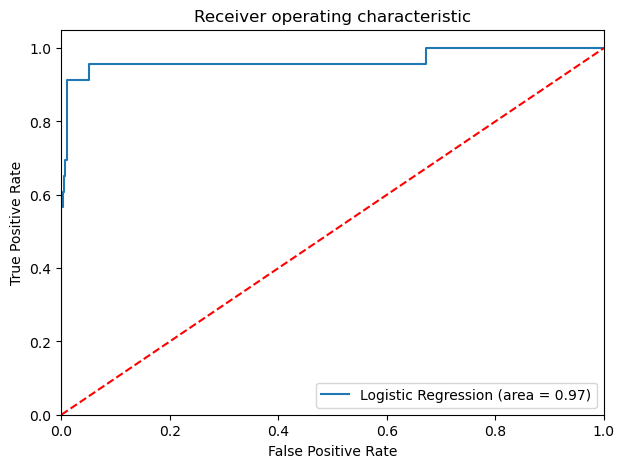

In [18]:
# Calculating the ROC AUC score using the probabilities for the positive class
logit_roc_auc_train = roc_auc_score(y_train, lg.predict_proba(X_train)[:, 1])

# Generating the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])

# Creating a figure with specified size
plt.figure(figsize=(7, 5))

# Plotting the ROC curve with the AUC score as a label
plt.plot(fpr, tpr, label=f"Logistic Regression (area = {logit_roc_auc_train:.2f})")

# Adding a red dashed line that represents a random classifier
plt.plot([0, 1], [0, 1], "r--")

# Setting the limits for the X and Y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Adding labels and title to the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")

# Adding a legend in the lower right corner
plt.legend(loc="lower right")

# Displaying the plot
plt.show()

### Model Performance Improvement

* Let's see if the recall score can be improved further, by changing the model threshold using AUC-ROC Curve.

### Optimal threshold using AUC-ROC curve Training set
#### Methodology Behind Finding the Optimal Threshold
The script calculates the optimal threshold using the Receiver Operating Characteristic (ROC) curve, which is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

True Positive Rate (TPR), also known as sensitivity, measures the proportion of actual positives that are correctly identified as such.
False Positive Rate (FPR), is the proportion of actual negatives that are incorrectly identified as positives.
The optimal threshold is found by looking for the point where the difference between the TPR and FPR is the greatest. This point is typically chosen because it signifies a balance where the increase in TPR (we capture more true positives) is substantial compared to the increase in FPR (we falsely classify fewer negatives as positives). This method essentially maximizes the model's discrimination capability between the positive and negative classes.

In [20]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.12149856014315798


### Observations
#### Implications of the Optimal Threshold (0.12149)
1. **Lower Threshold:** The optimal threshold of about 0.12149 is relatively low. This suggests that the model starts predicting the positive class at a lower probability threshold, which can be beneficial if the cost of missing a true positive (Type II error) is higher than the cost of falsely identifying a negative as a positive (Type I error). For example, in medical diagnostics for a severe disease, missing an actual disease case could be more detrimental than falsely diagnosing the disease.
2. **Sensitivity vs. Specificity:** A lower threshold typically increases the sensitivity of the model, as it lowers the barrier for predicting positives. However, this might come at the expense of specificity (the ability to correctly identify negatives), as lowering the threshold generally increases the false positive rate.

#### Checking model performance on training and testin set

In [21]:
# Creating confusion matrix over the training with optimized threshold
model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)

,Accuracy,Recall,Precision,F1
0,0.918919,0.777778,0.5,0.608696


In [22]:
# Checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.948081,0.913043,0.5,0.646154


#### Let's use Precision-Recall curve and see if we can find a better threshold

The script generates a plot that visualizes how precision and recall vary with the threshold used to classify observations as positive or negative. Here are key points to understand from this plot:

1. **Precision:** The proportion of positive identifications that were actually correct. It is plotted in blue dashed lines. Precision is sensitive to false positives.
2. **Recall (Sensitivity):** The proportion of actual positives that were identified correctly. It is plotted in green dashed lines. Recall is sensitive to false negatives.
Insights from the Plot
3. **Trade-off Visualization:** The plot shows the trade-off between precision and recall for different thresholds. As the threshold increases, precision tends to increase (fewer false positives), but recall usually decreases (more false negatives).
4. **Choosing a Threshold:** This visualization helps in selecting an appropriate threshold based on the requirements:
If it's critical to ensure that all positive predictions are highly likely to be correct (high precision), a higher threshold may be appropriate.
If it's more important to capture as many positives as possible (high recall), a lower threshold might be better.

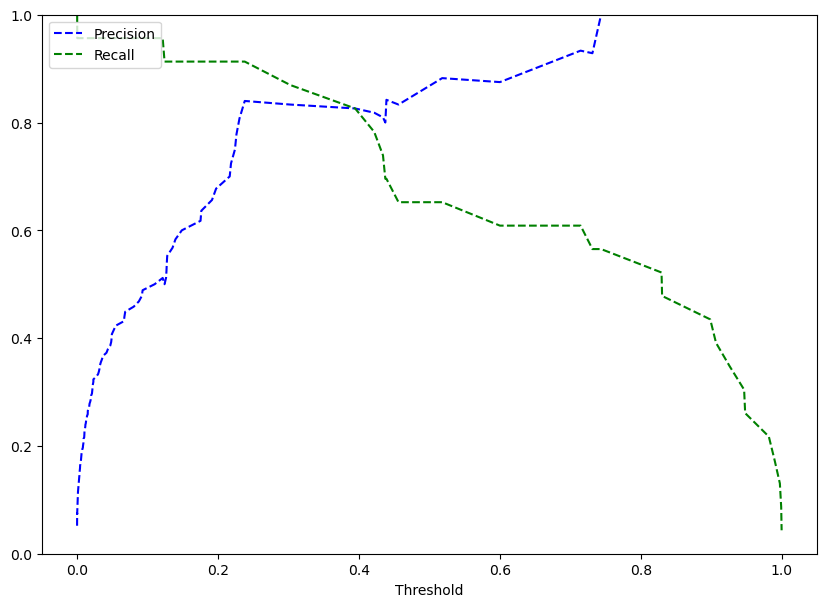

In [23]:
from sklearn.metrics import precision_recall_curve  # Importing the precision-recall curve function

# Predicting probabilities for the positive class
y_scores = lg.predict_proba(X_train)[:, 1]

# Calculating precision and recall for various thresholds
prec, rec, tre = precision_recall_curve(y_train, y_scores)

# Defining a function to plot precision and recall as functions of the threshold
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")  # Plotting precision
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")  # Plotting recall
    plt.xlabel("Threshold")  # X-label
    plt.legend(loc="upper left")  # Legend position
    plt.ylim([0, 1])  # Y-axis limits

# Setting up the figure size for the plot
plt.figure(figsize=(10, 7))

# Calling the function to plot precision and recall against the thresholds
plot_prec_recall_vs_tresh(prec, rec, tre)

# Displaying the plot
plt.show()


* At threshold around 0.4 we will get equal precision and recall.

In [24]:
# Setting the threshold
optimal_threshold_curve = 0.40

#### Checking model performance on training set

In [25]:
#  Creating confusion matrix training set with optimal threshold = 0.40
model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)

,Accuracy,Recall,Precision,F1
0,0.945946,0.777778,0.636364,0.7


In [26]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.979684,0.782609,0.818182,0.8


### Observations
1. Recalls have improved as compared to the initial model.
2. Model with a threshold as 0.4 was giving a better recalls (0.78) but no better than with an optimized threshold of 0.894

### Model Performance Summary

In [28]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression = 0.12149 Threshold",
    "Logistic Regression = 0.4 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression = 0.12149 Threshold,Logistic Regression = 0.4 Threshold
Accuracy,0.977427,0.948081,0.979684
Recall,0.652174,0.913043,0.782609
Precision,0.882353,0.500000,0.818182
F1,0.750000,0.646154,0.800000


### Observations
### Analysis of Results
**Standard Logistic Regression (No Custom Threshold):**
1. Accuracy: Highest at 97.7427%, suggesting excellent overall performance.
2. Recall: Lower at 65.2174%, indicating some positives are missed.
3. Precision: Good at 88.2353%, showing strong accuracy in its positive predictions.
4. F1 Score: 75%, balancing recall and precision moderately well.

**Logistic Regression with 0.12149 Threshold:**
1. Accuracy: Lower at 94.8081%, a small trade-off for drastically improved recall.
2. Recall: Significantly higher at 91.3043%, capturing more positives at the expense of more false positives.
3. Precision: Lower at 50%, reflecting the cost of a lower threshold increasing false positives.
4. F1 Score: 64.6154%, showing better balance due to the improved recall.

**Logistic Regression with 0.4 Threshold:**

1. Accuracy: Nearly as high as the standard model at 97.9684%.
2. Recall: Better than the standard but lower than the low threshold model at 78.2609%.
3. Precision: Higher at 81.8182% compared to the lower threshold setting, showing fewer false positives.
4. F1 Score: 80%, indicating a balanced trade-off at this threshold.

**Summary of Findings**

**Trade-offs:** The results demonstrate classic trade-offs between recall and precision. Lowering the threshold to 0.12149 improves recall significantly, making the model sensitive but less precise. Increasing the threshold to 0.4 reduces recall slightly but improves precision, making the model more conservative.

**Choosing the Best Model:** The choice between these models depends on the specific requirements of the task:
If it's critical to capture as many positives as possible (e.g., in disease screening), the lower threshold might be preferable.
If precision is more important (e.g., in spam detection where false positives are disruptive), a higher threshold could be better.

**Optimal Balance:** The model with a threshold of 0.4 appears to offer a good balance, maintaining high accuracy and a better recall-precision trade-off compared to the standard model.

### Let's check the performance on the test set

**Using the model with default threshold**

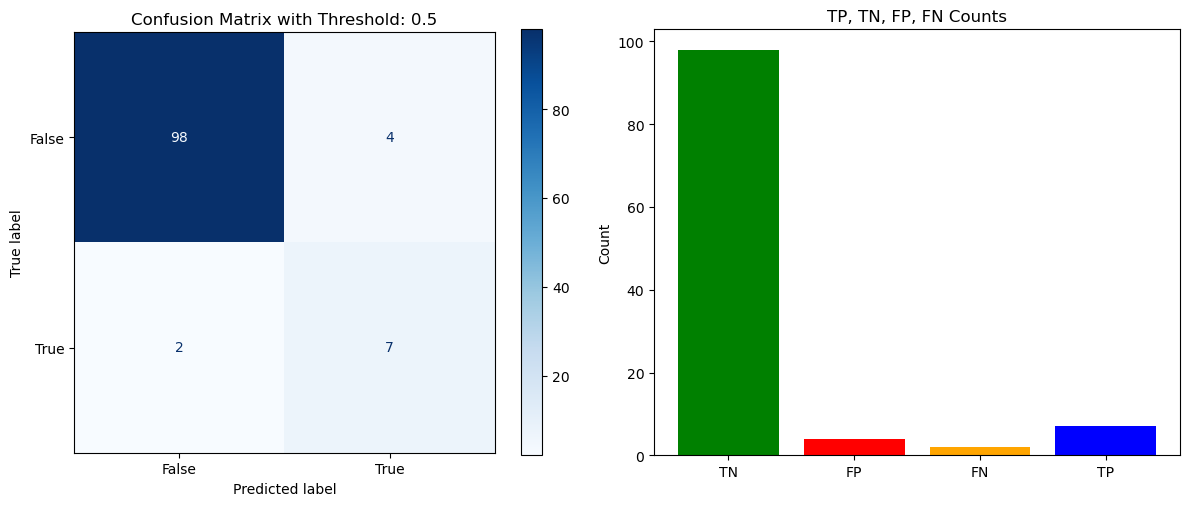

In [29]:
# Creating confusion matrix over the test set with no threshold change
confusion_matrix_sklearn_with_threshold(lg, X_test, y_test)

In [30]:
log_reg_model_test_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test
)

print("Test set performance:")
log_reg_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.945946,0.777778,0.636364,0.7


### Observations
1. The Logistic Regression model gives a good Accuracy (0.98) on the test set, but the recall (0.5) is not as good as expected.


* ROC-AUC on test set

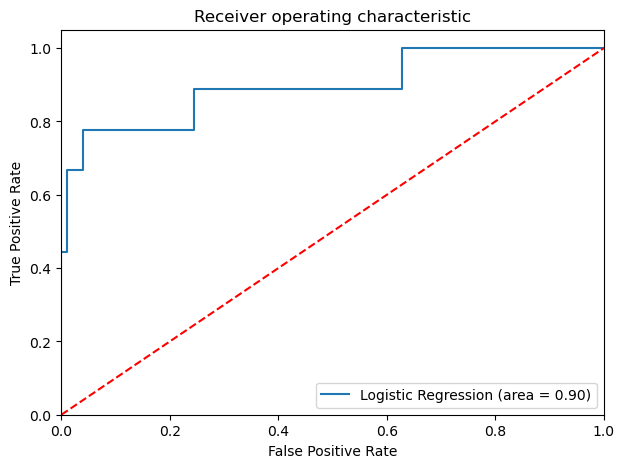

In [31]:
# Calculating the ROC AUC score using the probabilities for the positive class from the test data
logit_roc_auc_test = roc_auc_score(y_test, lg.predict_proba(X_test)[:, 1])

# Generating the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:, 1])

# Creating a figure with specified size for better visualization
plt.figure(figsize=(7, 5))

# Plotting the ROC curve with the AUC score as a label
plt.plot(fpr, tpr, label=f"Logistic Regression (area = {logit_roc_auc_test:.2f})")

# Adding a red dashed line that represents a random classifier
plt.plot([0, 1], [0, 1], "r--")

# Setting the limits for the X and Y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Adding labels and a title to the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")

# Adding a legend in the lower right corner
plt.legend(loc="lower right")

# Displaying the plot
plt.show()

**Using the model with threshold of 0.14499**

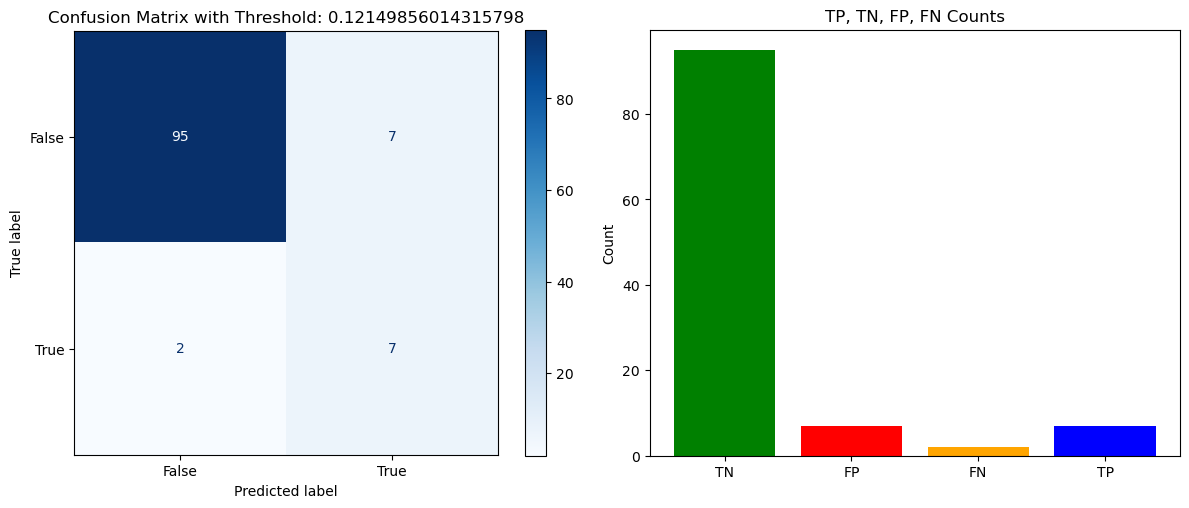

In [32]:
# Creating confusion matrix over the test set with optimal threshold
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)

In [33]:
# checking model performance for this model
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)
print("Test set performance:")
log_reg_model_test_perf_threshold_auc_roc

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.918919,0.777778,0.5,0.608696


**Using the model with threshold 0.4**

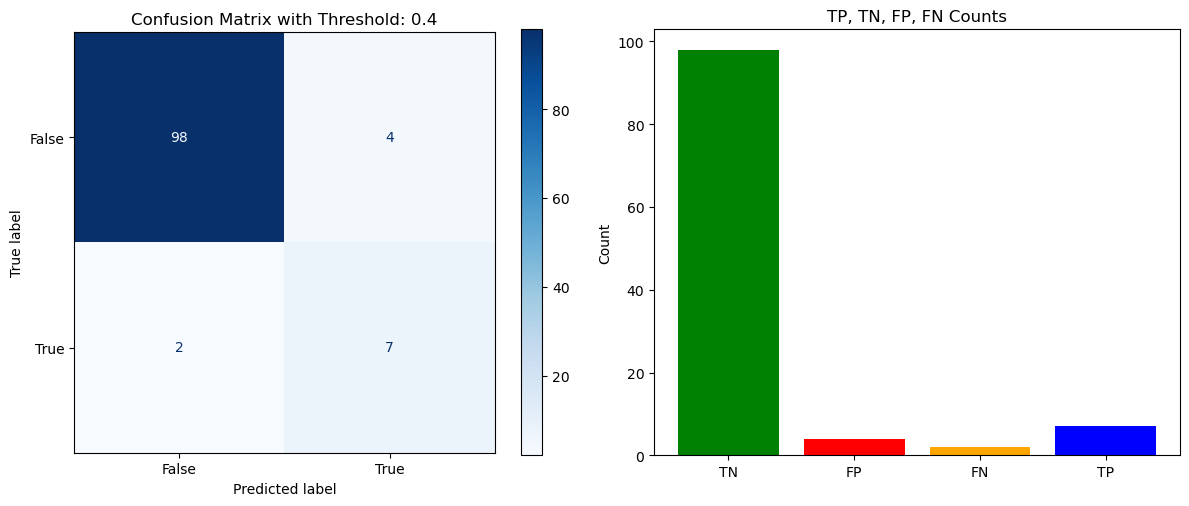

In [34]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)

In [35]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)
print("Test performance:")
log_reg_model_test_perf_threshold_curve

Test performance:


,Accuracy,Recall,Precision,F1
0,0.945946,0.777778,0.636364,0.7


### Observations
1. Recalls have improved as compared to the initial model.
2. Model with a threshold of 0.4 was giving better accuracy (0.98) 

## 5) Model performance evaluation and improvement

In [37]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
     "Logistic Regression sklearn",
    "Logistic Regression 0.12149 Threshold",
    "Logistic Regression-0.4 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression 0.12149 Threshold,Logistic Regression-0.4 Threshold
Accuracy,0.977427,0.948081,0.979684
Recall,0.652174,0.913043,0.782609
Precision,0.882353,0.500000,0.818182
F1,0.750000,0.646154,0.800000


## Observations

**Metrics Analysis**
**Accuracy:**
1. Standard Model: Highest accuracy at 97.07%, indicating overall excellent correct classification rate for both classes.
2. 0.12149 Threshold: Accuracy drops to 94.80%, a slight decrease which may suggest more false positives due to a lower threshold.
3. 0.4 Threshold: Slightly lower than the standard model at 97.96% but higher than the lower threshold, suggesting better overall classification than at 0.12149.

**Recall (Sensitivity):**
1. Standard Model: Moderate at 65.52%. This shows that the model, with default settings, misses a significant number of positive cases.
2. 0.12149 Threshold: Significantly higher at 91.30%. Lowering the threshold considerably increases the model's ability to detect positive cases, reducing the number of false negatives.
3. 0.4 Threshold: Increased to 78.26% compared to the standard setting, but not as high as with the 0.14499 threshold, balancing the detection of positives with a reduction in false positives.

**Precision:**
1. Standard Model: Quite high at 88.23%, indicating that a large proportion of the positive predictions made by the model are correct.
2. 0.12149 Threshold: Drops to 50.00 %, reflecting an increase in false positives as the threshold lowers, which aligns with the higher recall.
3. 0.4 Threshold: Better precision at 81.8% than with the lower threshold, suggesting fewer false positives but at the cost of missing some true positives.

**F1 Score:**
1. Standard Model: Balanced score of 75.0%, indicating a good balance between precision and recall in the default model.
2. 0.12149 Threshold: A slight decrease to 6461%, showing that while the model is better at identifying positive cases (higher recall), it does so at the expense of precision.
3. 0.4 Threshold: Comparable to the standard model at 80.00%, indicating a good balance despite the adjustment in the threshold.

**Conclusion and Strategic Recommendations**
**Trade-Offs:** These results clearly illustrate the trade-off between recall and precision. Lowering the threshold significantly increases recall but decreases precision, making the model more sensitive but less specific. Raising the threshold moderately improves precision at a slight cost to recall.

**Choice of Model:** The choice between these thresholds depends on the specific application:
If missing a positive case has serious consequences a lower threshold (0.12149) might be preferable despite its lower precision.
For applications where false positives carry a higher cost , a higher threshold (0.4) might be more appropriate.
The standard model offers a balanced approach but might not be suitable for contexts where high sensitivity is critical.


In [38]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
     "Logistic Regression sklearn",
    "Logistic Regression 0.12149 Threshold",
    "Logistic Regression-0.4 Threshold",
]

print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression sklearn,Logistic Regression 0.12149 Threshold,Logistic Regression-0.4 Threshold
Accuracy,0.945946,0.918919,0.945946
Recall,0.777778,0.777778,0.777778
Precision,0.636364,0.500000,0.636364
F1,0.700000,0.608696,0.700000


## 6) Build Decision Tree Model

#### First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_sklearn function will be used to check the model performance of models. 
* The make_confusion_matrix function will be used to plot confusion matrix.

## Build Decision Tree Model

In [39]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="gini", random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

#### Checking model performance on training set

In [41]:
decision_tree_perf_train = model_performance_classification_sklearn_with_threshold(
    model, X_train, y_train
)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


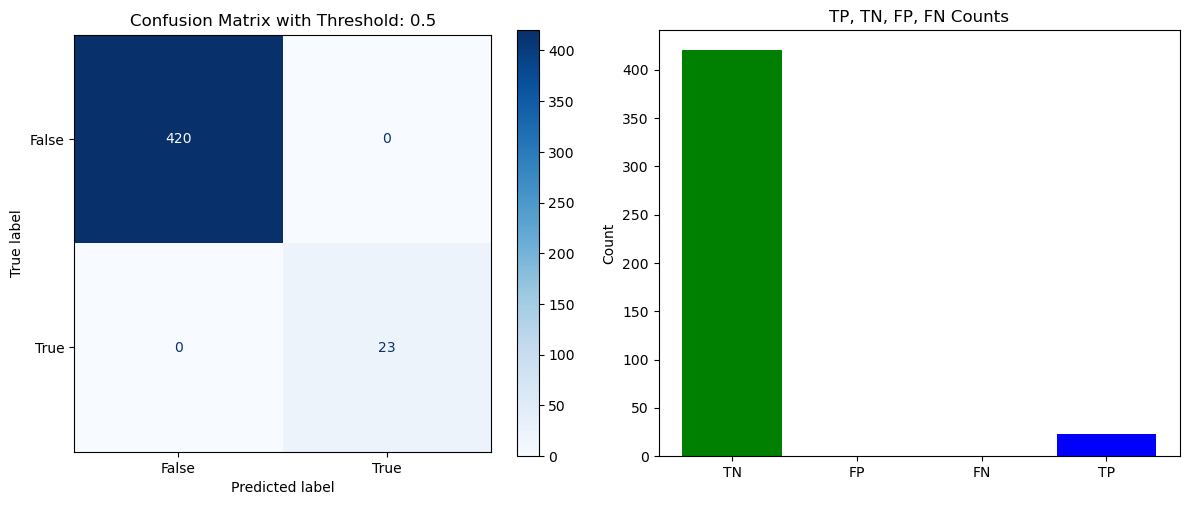

In [42]:
confusion_matrix_sklearn_with_threshold(model, X_train, y_train)

### Observation
1. The models is overfitting  on the training set

#### Checking model performance on test set

In [44]:
decision_tree_perf_test = model_performance_classification_sklearn_with_threshold(
    model, X_test, y_test
)
decision_tree_perf_test

,Accuracy,Recall,Precision,F1
0,0.927928,0.555556,0.555556,0.555556


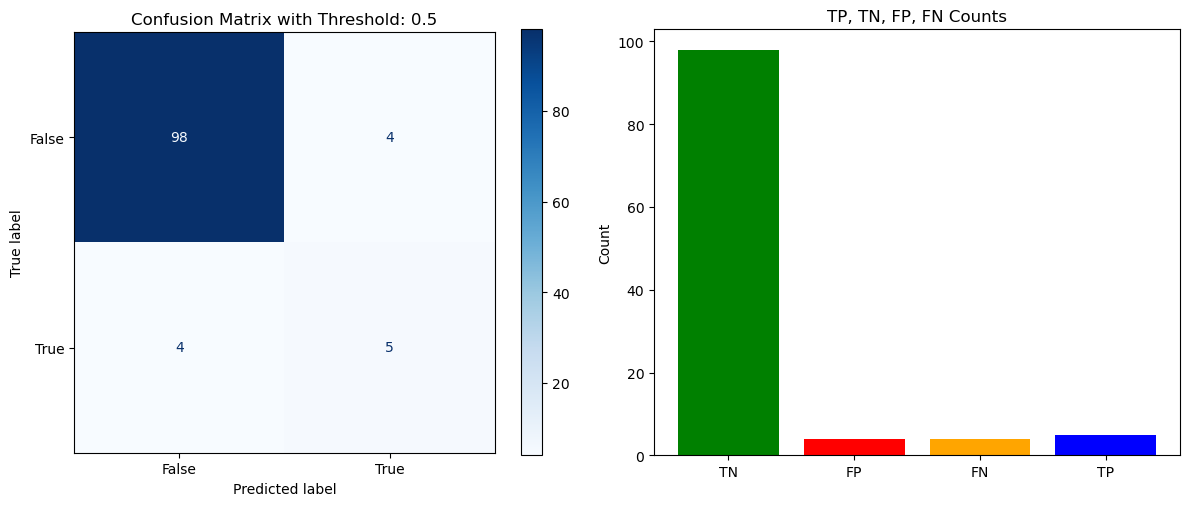

In [45]:
confusion_matrix_sklearn_with_threshold(model, X_test, y_test)

## Visualizing the Decision Tree

In [46]:
column_names = list(X.columns)
feature_names = column_names
print(feature_names)

['pH', 'Temp', 'OD', 'Cond', 'Redox', 'Color', 'Turb', 'TOC']


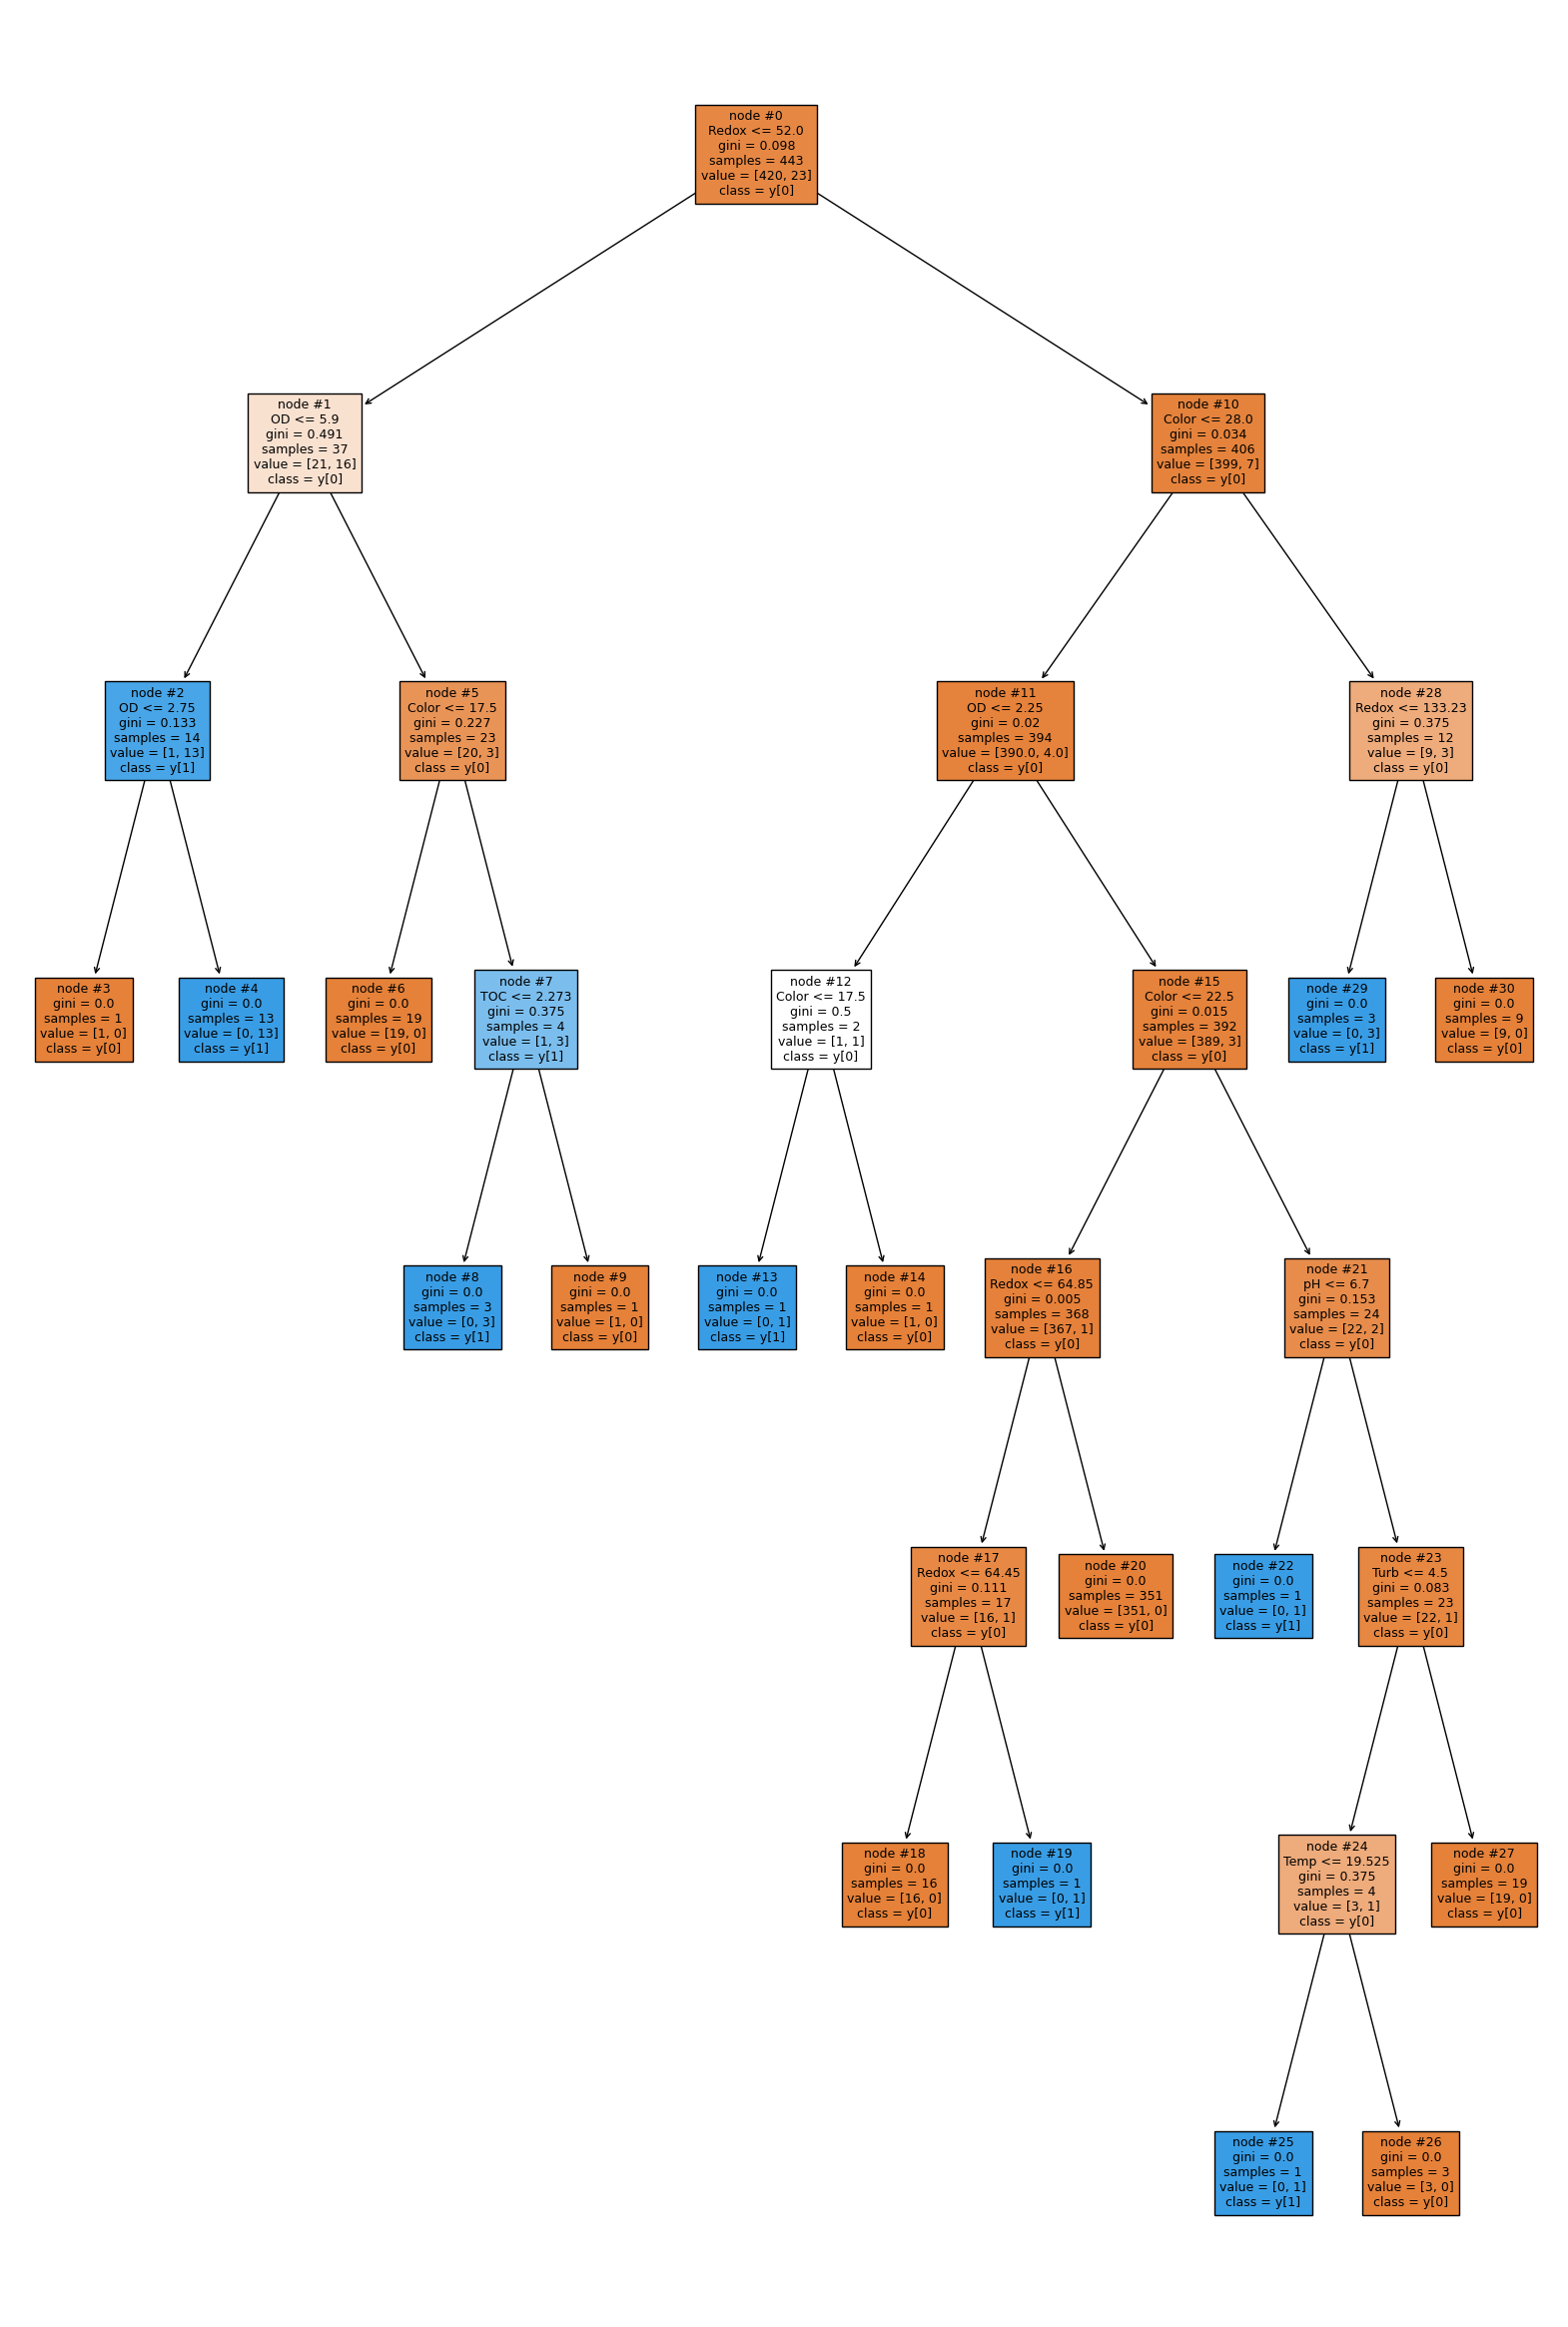

In [47]:
from sklearn import tree

plt.figure(figsize=(20, 30))

out = tree.plot_tree(
    model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=True,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

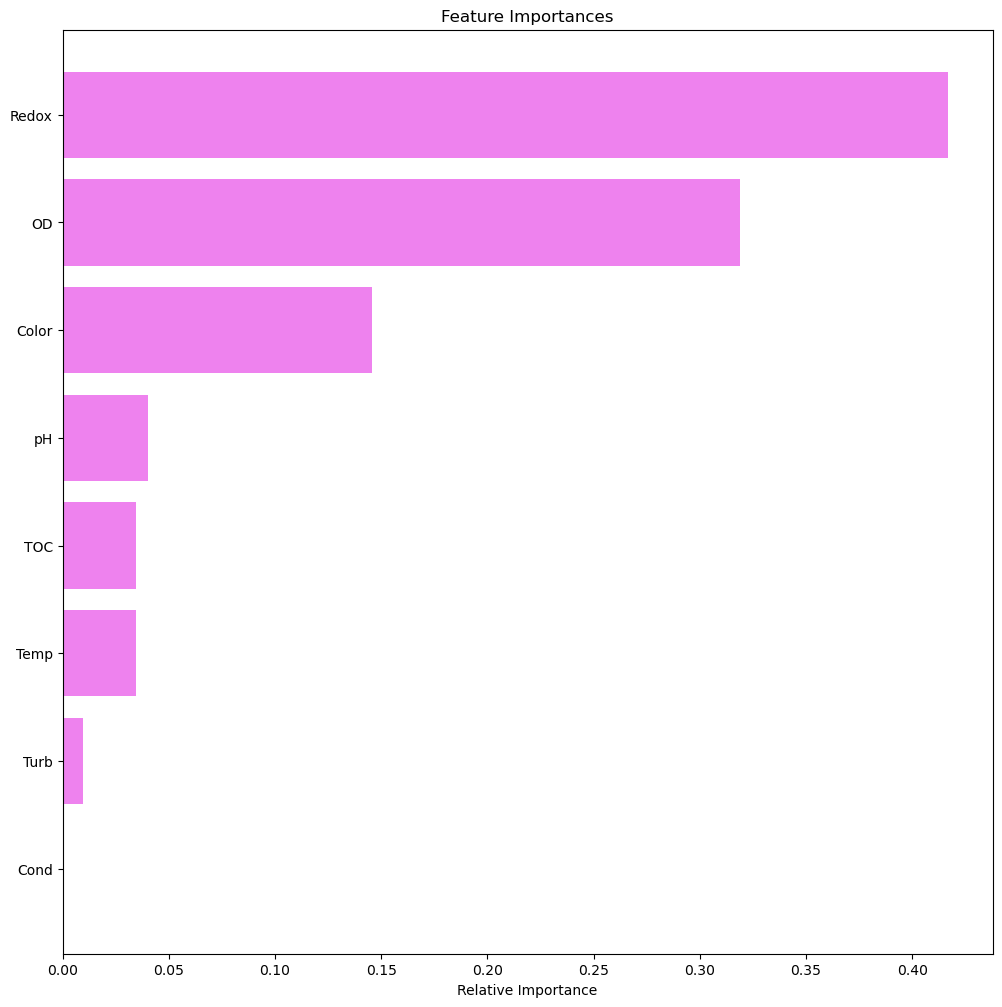

In [49]:
# Retrieve feature importances from the trained model
importances = model.feature_importances_

# Sort the indices of the features based on their importance values
indices = np.argsort(importances)

# Set up a figure with a specified size (12 inches wide by 12 inches tall)
plt.figure(figsize=(12, 12))

# Add a title to the plot
plt.title("Feature Importances")

# Create a horizontal bar chart to display the feature importances
# range(len(indices)) creates a sequence of positions on the y-axis
# importances[indices] determines the length of each bar based on feature importance
# 'color="violet"' sets the color of the bars
# 'align="center"' ensures that the bars are centered on the y-tick labels
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")

# Set y-ticks with the feature names sorted by importance
# range(len(indices)) specifies the tick positions on the y-axis
# [feature_names[i] for i in indices] provides the labels in ascending order of importance
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

# Label the x-axis as "Relative Importance"
plt.xlabel("Relative Importance")

# Display the plot
plt.show()

### Observations

1. Redox: This feature has the highest importance in the model, with a significant margin compared to others. It appears to be the most influential factor in the predictions made by your model.
2. OD (Oxygen Demand?): The second most important feature, which also has a substantial impact on the model's output. This suggests that variations in oxygen demand are critical for predicting the target variable.
3. Color: This feature holds moderate importance. It is considerably less influential than Redox and OD but still significantly affects the model's predictions.
4. pH: This shows a lower level of importance relative to the top three features but still plays a role in the model's decision-making process.
5. TOC (Total Organic Carbon): Similar to pH, TOC has a modest impact on the model’s predictions.
6. Temp (Temperature): Shows relatively low importance, indicating that temperature variations have a minor influence on the outcomes compared to other features.
7. Turb (Turbidity): Very low importance, suggesting that turbidity has minimal impact on the model’s predictions.
8. Cond (Conductivity): The least important feature in this model. Its impact on model predictions is minimal, suggesting that changes in conductivity are less relevant for the outcome of the model.

### Using GridSearch for Hyperparameter tuning of our tree model 
* Let's see if we can improve our model performance even more.

In [50]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from

parameters = {
   'max_depth': [3, 5, 10, None],  # Correctly specify as list of integers and None
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=1)

#### Checking performance on training set

In [52]:
decision_tree_tune_perf_train = model_performance_classification_sklearn_with_threshold(
    estimator, X_train, y_train
)
decision_tree_tune_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


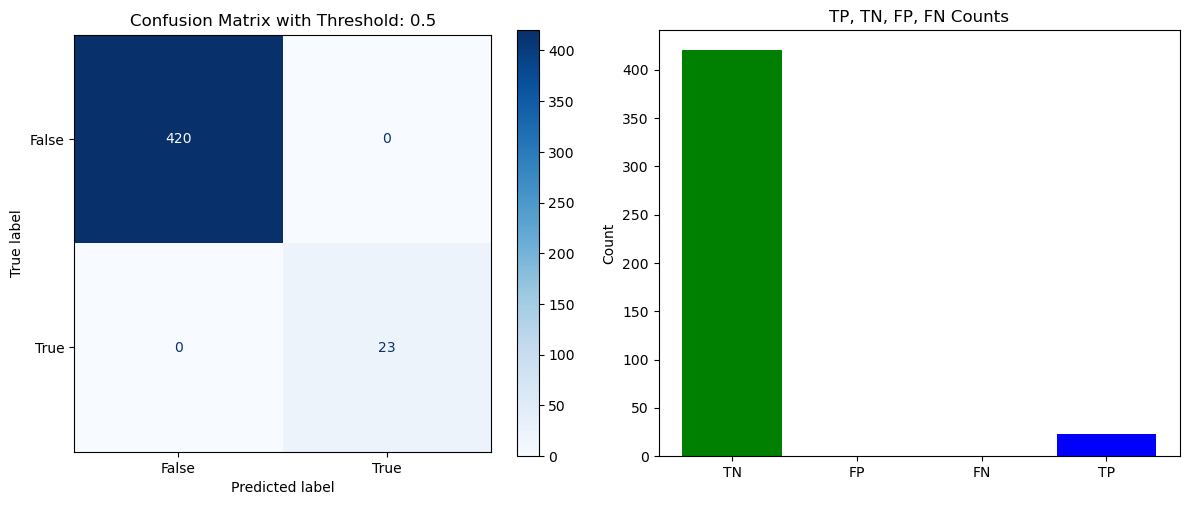

In [53]:
confusion_matrix_sklearn_with_threshold(estimator, X_train, y_train)

### Observations
1. Similar to the previous model, the GridSearch model overfit on the training set

#### Checking model performance on test set

In [55]:
decision_tree_tune_perf_test = model_performance_classification_sklearn_with_threshold(
    estimator, X_test, y_test
)

decision_tree_tune_perf_test

,Accuracy,Recall,Precision,F1
0,0.927928,0.555556,0.555556,0.555556


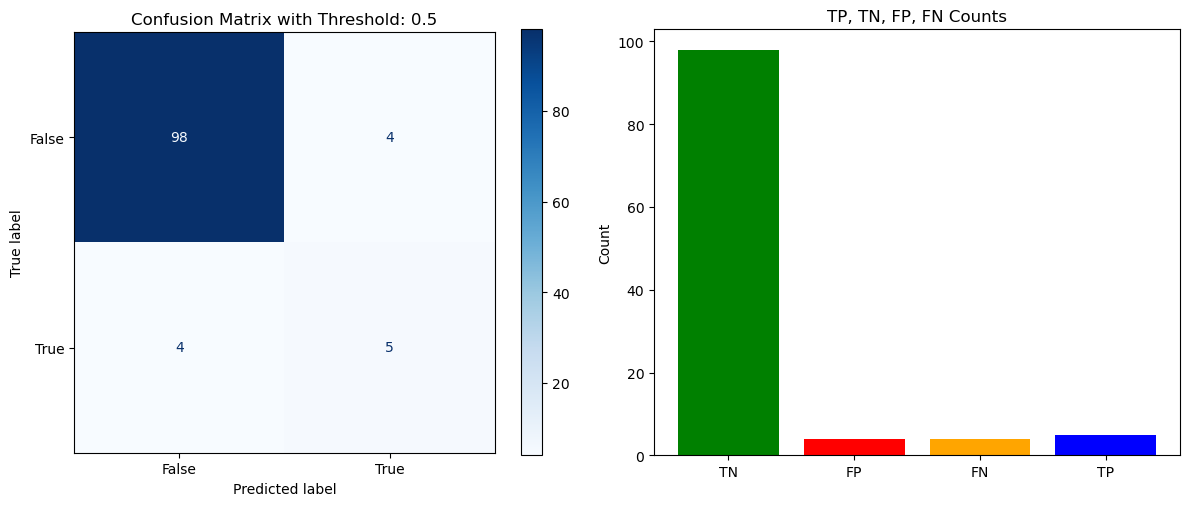

In [56]:
confusion_matrix_sklearn_with_threshold(estimator, X_test, y_test)

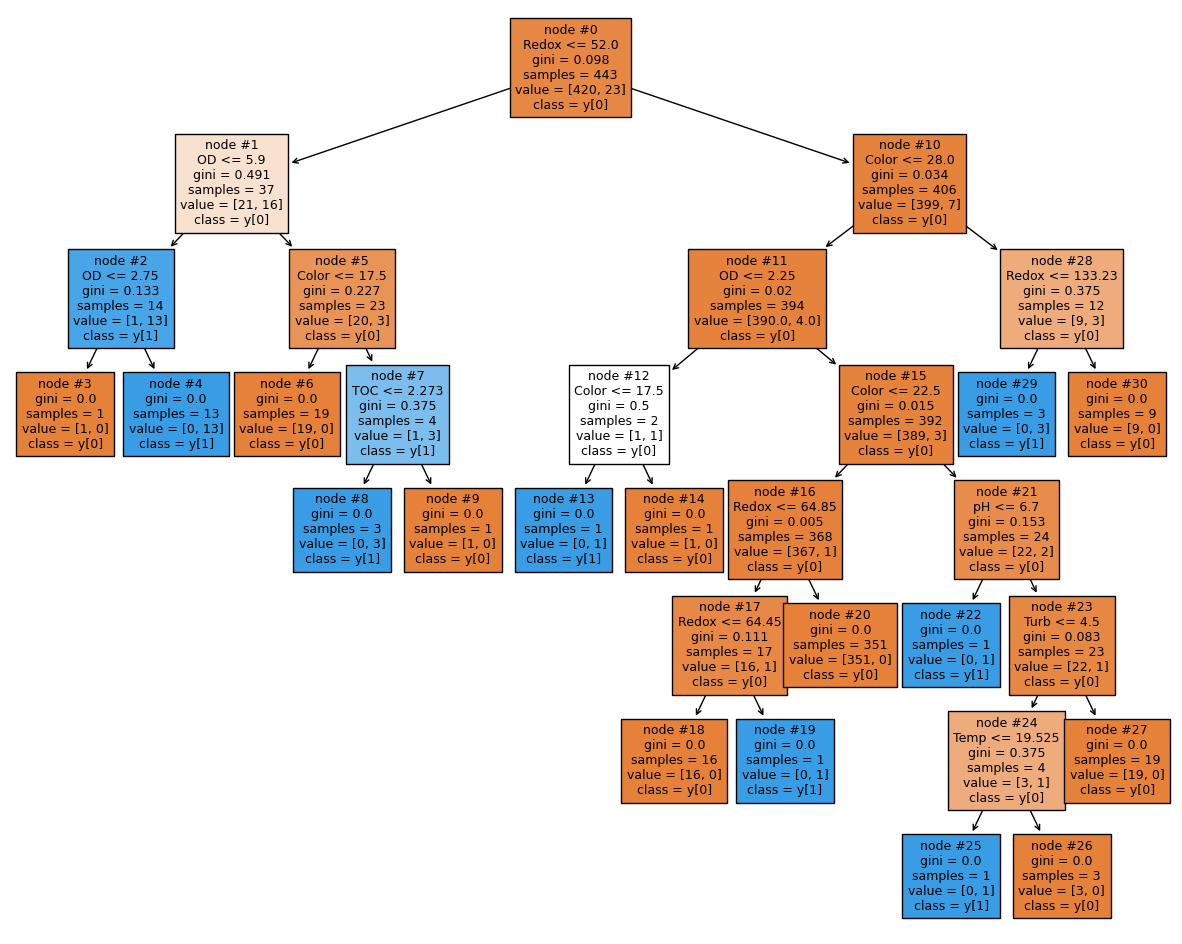

In [57]:
plt.figure(figsize=(15, 12))

tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=True,
)
plt.show()

### Observations:

1. The model is mores simplified tree as expected  after pre-pruning.

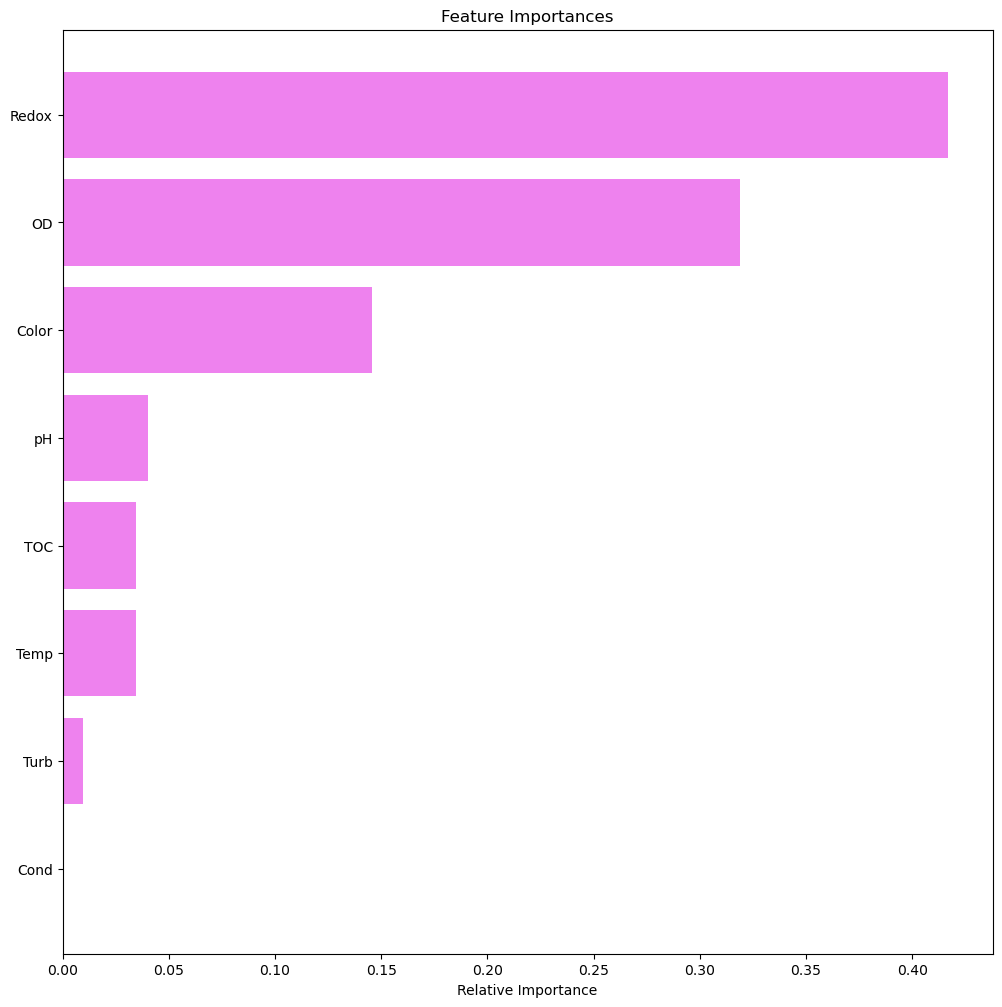

In [58]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Cost Complexity Pruning

In [62]:

# Initialize the decision tree classifier with a specific random state for reproducibility
clf = DecisionTreeClassifier(random_state=1)

# Calculate the cost-complexity pruning path for the decision tree
# This method returns thresholds (alphas) at which the tree is pruned and the corresponding total impurities of the pruned trees
path = clf.cost_complexity_pruning_path(X_train, y_train)

# Extract the alpha values (pruning parameters) and corresponding impurities from the pruning path
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [63]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000000,0.000000
1,0.002159,0.004318
2,0.002251,0.008821
3,0.002257,0.011078
4,0.002266,0.017875
5,0.003386,0.021261
6,0.004192,0.025454
7,0.006591,0.038636
8,0.008391,0.047027
9,0.025029,0.072056


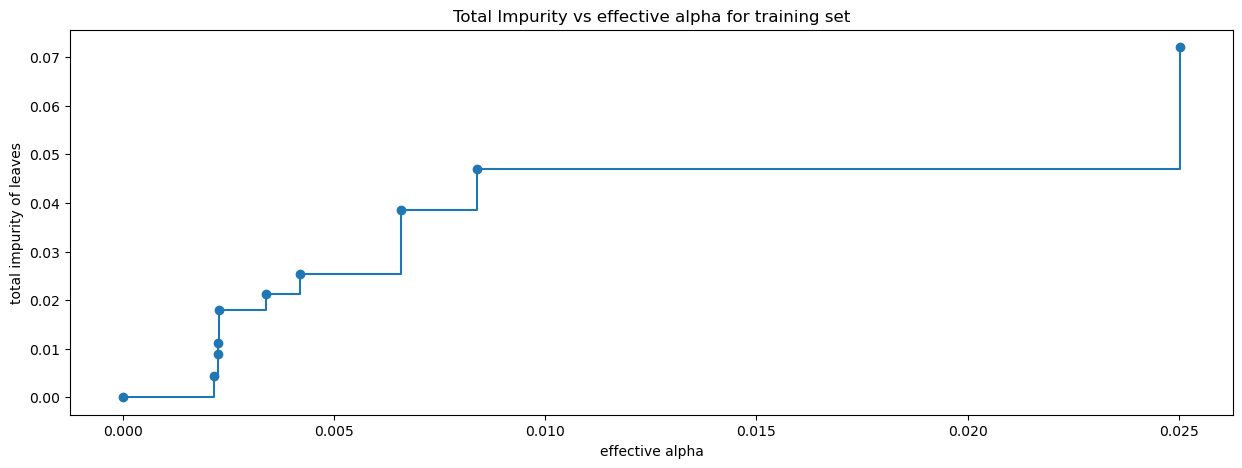

In [64]:

# Create a subplot with a specified figure size
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the impurities as a function of effective alpha values, using o markers and steps-post drawstyle
# 'steps-post' indicates that the step rises after the point (effective for visualizing changes at each step)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")

# Set the label for the x-axis
ax.set_xlabel("effective alpha")

# Set the label for the y-axis
ax.set_ylabel("total impurity of leaves")

# Set the title of the plot
ax.set_title("Total Impurity vs effective alpha for training set")

# Display the plot
plt.show()


Training a decision tree using the effective alphas. The last value
in ``ccp_alphas`` is the alpha value that prunes the whole tree,
leaving the tree, ``clfs[-1]``, with one node.

In [65]:
# Initialize an empty list to store the trained classifiers
clfs = []

# Iterate over different values of ccp_alpha
for ccp_alpha in ccp_alphas:
    # Create a DecisionTreeClassifier with the specified random state and ccp_alpha
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    
    # Train the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Append the trained classifier to the list
    clfs.append(clf)

# Print the number of nodes in the last tree along with its corresponding ccp_alpha value
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)


Number of nodes in the last tree is: 1 with ccp_alpha: 0.02639041827802896


Removing the last element in
``clfs`` and ``ccp_alphas``, because it is the trivial tree with only one
node. Here we show that the number of nodes and tree depth decreases as alpha
increases.

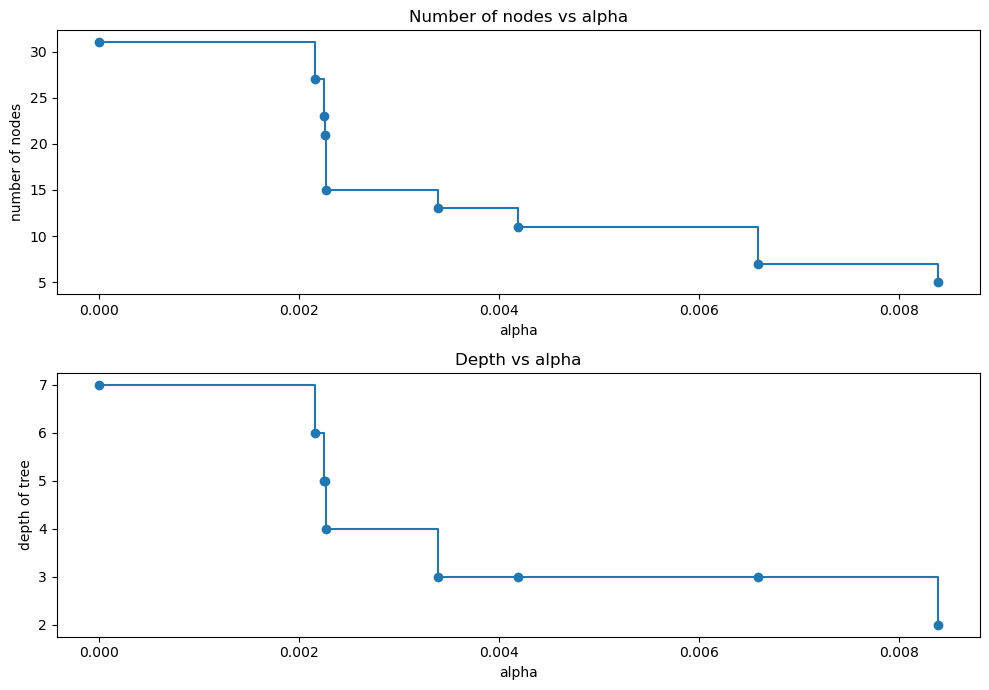

In [67]:
# Remove the last element from the list of trained classifiers and ccp_alphas
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Extract the number of nodes and depth of trees for each classifier
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

# Plot number of nodes vs alpha
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

# Plot depth vs alpha
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")

# Adjust layout to prevent overlap of subplots
fig.tight_layout()


Recall vs alpha for training and testing sets
----------------------------------------------------

In [68]:
# Initialize an empty list to store recall scores on the training data
recall_train = []

# Iterate over each trained classifier
for clf in clfs:
    # Make predictions on the training data using the current classifier
    pred_train = clf.predict(X_train)
    
    # Calculate the recall score on the training data and append it to the list
    values_train = recall_score(y_train, pred_train)
    recall_train.append(values_train)


In [69]:
# Initialize an empty list to store recall scores on the test data
recall_test = []

# Iterate over each trained classifier
for clf in clfs:
    # Make predictions on the test data using the current classifier
    pred_test = clf.predict(X_test)
    
    # Calculate the recall score on the test data and append it to the list
    values_test = recall_score(y_test, pred_test)
    recall_test.append(values_test)


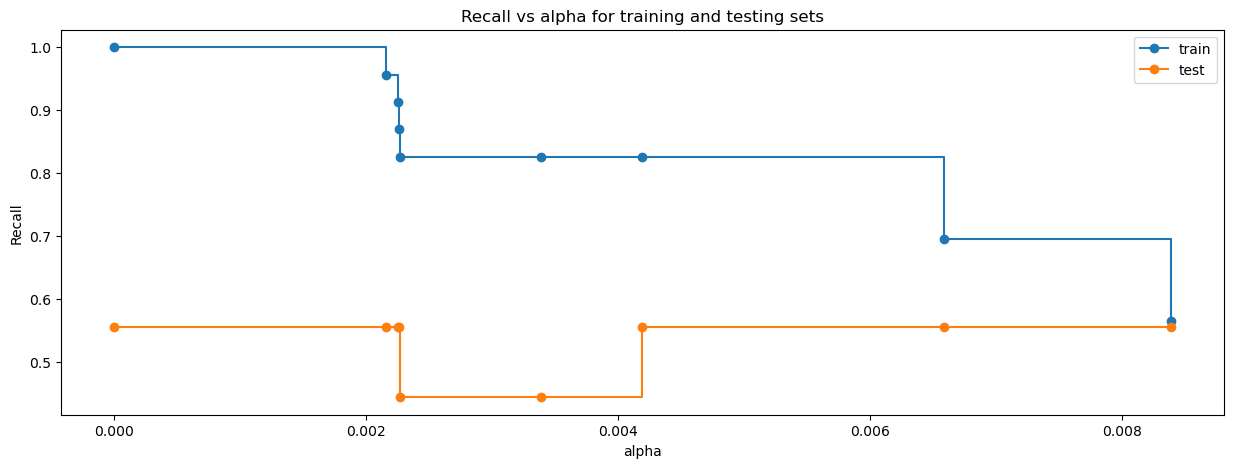

In [70]:
# Create a figure and axis object for plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Set labels and title for the plot
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")

# Plot recall scores for the training set
ax.plot(ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post")

# Plot recall scores for the testing set
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")

# Add legend to the plot
ax.legend()

# Display the plot
plt.show()


In [ ]:
# Creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

#### Checking model performance on training set

In [71]:
# Find the index of the model with the highest recall score on the test set
index_best_model = np.argmax(recall_test)

# Retrieve the best model using the index found
best_model = clfs[index_best_model]

# Print the best model
print(best_model)

DecisionTreeClassifier(random_state=1)


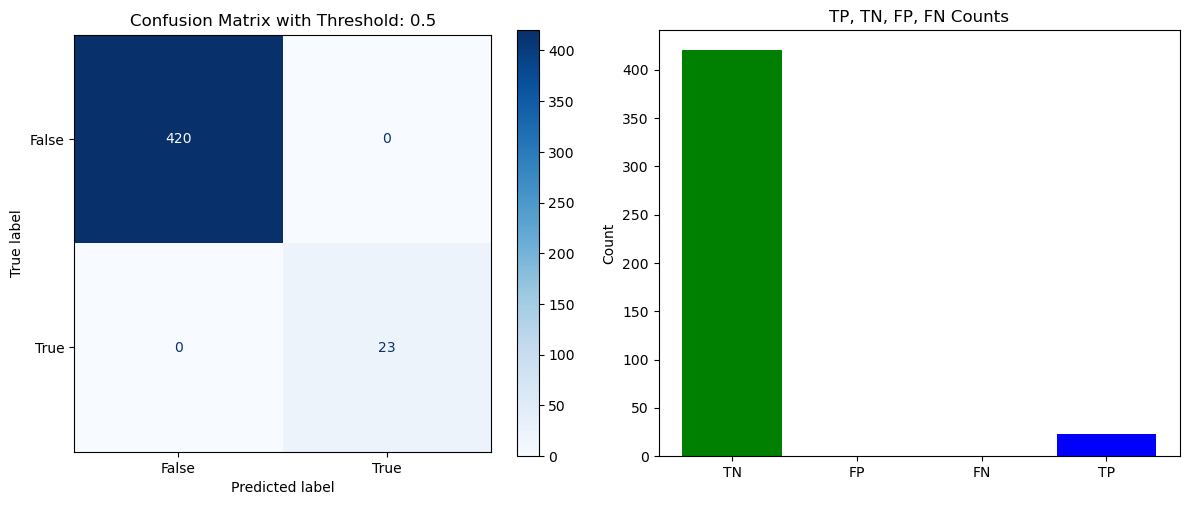

In [72]:
confusion_matrix_sklearn_with_threshold(best_model, X_train, y_train)

### Observations
1. Similar to the previous model, the Cost Complexity Pruning model,  overfit the training set

#### Checking model performance on test set

In [74]:
decision_tree_postpruned_perf_test = model_performance_classification_sklearn_with_threshold(
    best_model, X_test, y_test
)
decision_tree_postpruned_perf_test

,Accuracy,Recall,Precision,F1
0,0.927928,0.555556,0.555556,0.555556


In [83]:
decision_tree_postpruned_perf_train = model_performance_classification_sklearn_with_threshold(
    best_model, X_train, y_train
)
decision_tree_postpruned_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


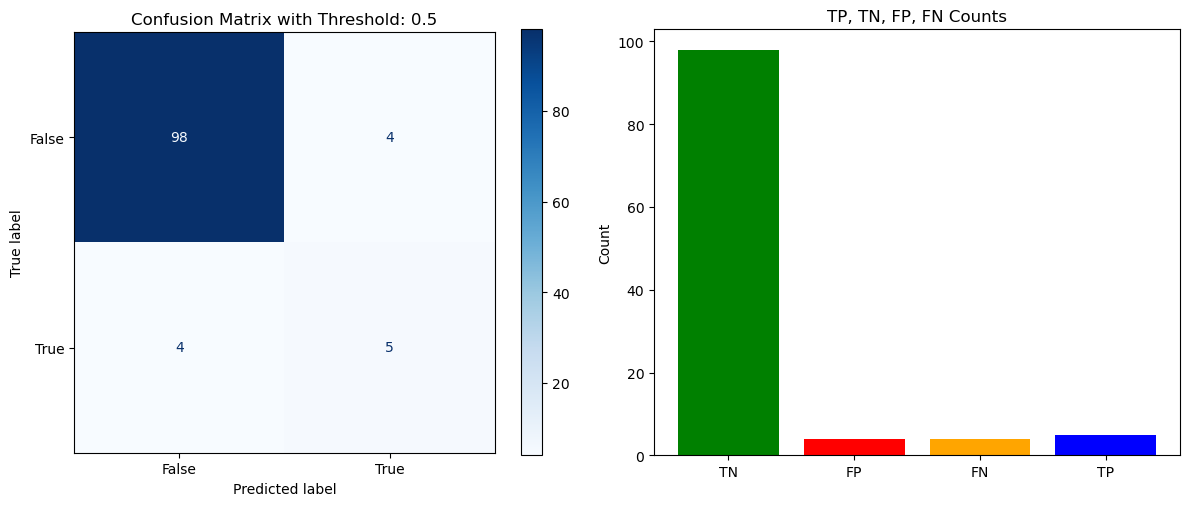

In [75]:
confusion_matrix_sklearn_with_threshold(best_model, X_test, y_test)

### Observation

1. With post-pruning, the model provides good and generalized model performance on both training and test set.


## Visualizing the Decision Tree

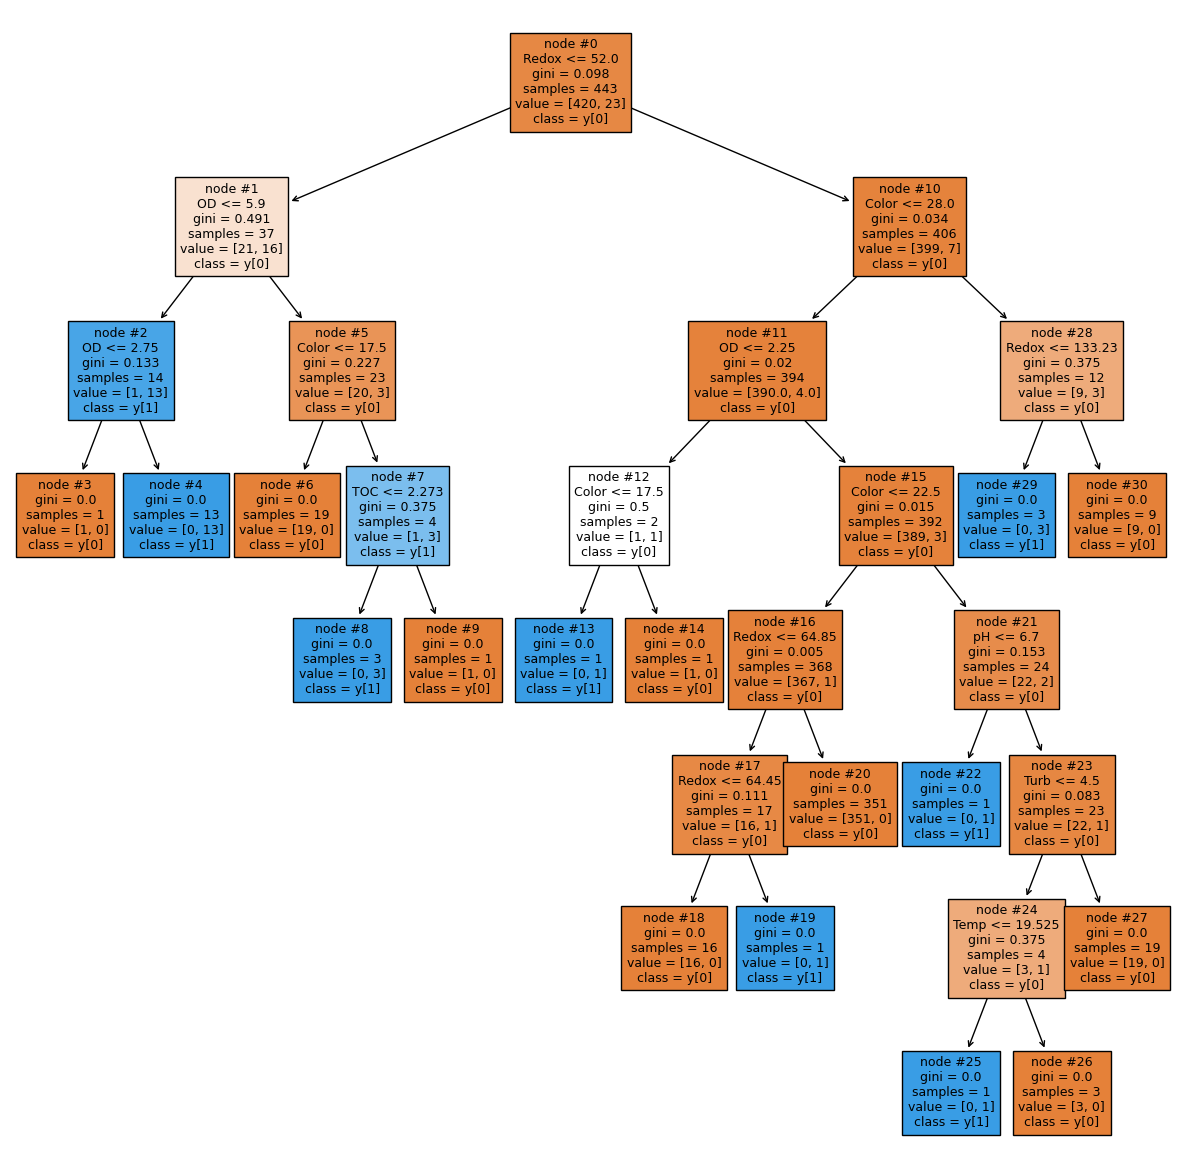

In [77]:
# Set the figure size for the plot
plt.figure(figsize=(15, 15))

# Plot the decision tree of the best model
out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=True,
    class_names=True,
)

# Customize the appearance of arrows in the plot
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)

# Show the plot
plt.show()


### Observations.

1. The obtained model is more simplified than the one produced by pre-running.


In [78]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        best_model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

            Imp
Redox  0.416987
OD     0.318939
Color  0.145605
pH     0.040210
Temp   0.034394
TOC    0.034394
Turb   0.009471
Cond   0.000000


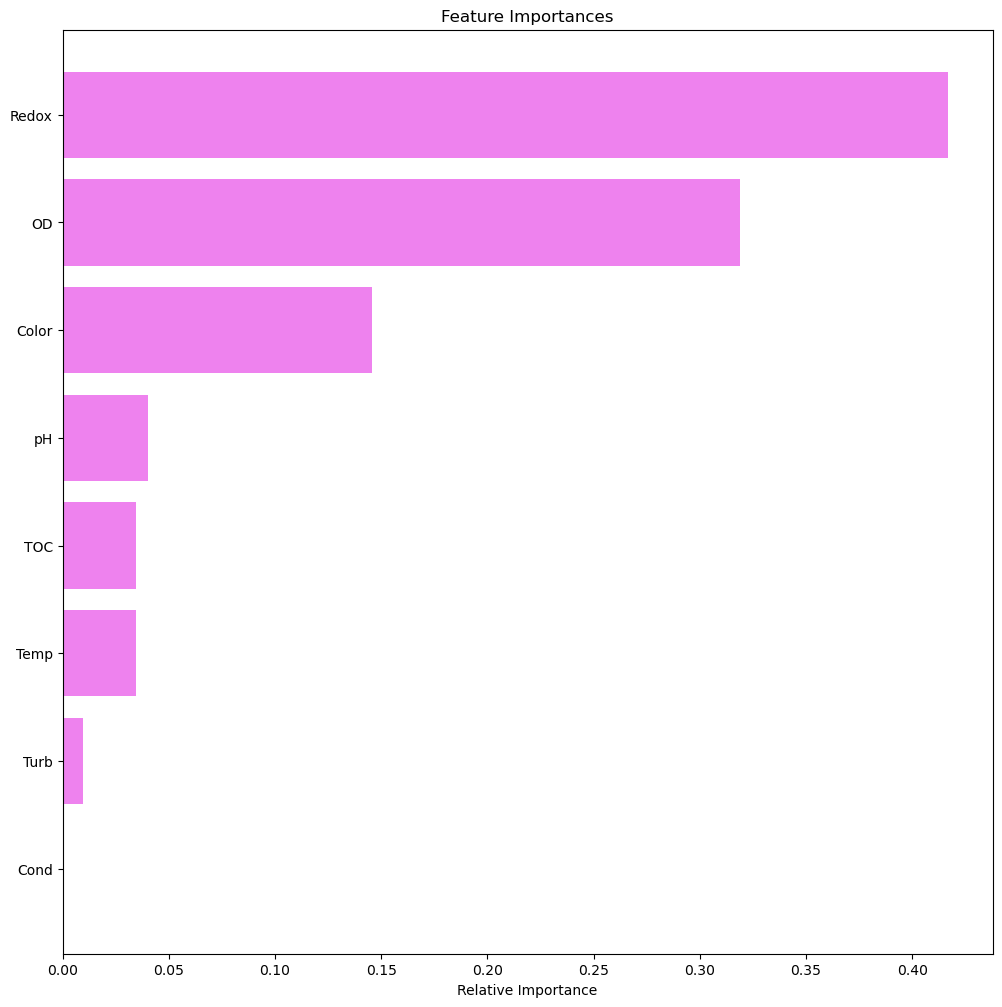

In [79]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## 7)  Model performance evaluation and improvement 

#### Comparing all the decision tree models

In [84]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train.T,
        decision_tree_tune_perf_train.T,
        decision_tree_postpruned_perf_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree sklearn",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree sklearn,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,1.0,1.0,1.0
Recall,1.0,1.0,1.0
Precision,1.0,1.0,1.0
F1,1.0,1.0,1.0


In [85]:
# test performance comparison

models_train_comp_df = pd.concat(
    [
        decision_tree_perf_test.T,
        decision_tree_tune_perf_test.T,
        decision_tree_postpruned_perf_test.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree sklearn",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Test set performance comparison:")
models_train_comp_df

Test set performance comparison:


,Decision Tree sklearn,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,0.927928,0.927928,0.927928
Recall,0.555556,0.555556,0.555556
Precision,0.555556,0.555556,0.555556
F1,0.555556,0.555556,0.555556


### Observations

